In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = 'Colab\ Notebooks/PROJECT'
%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/PROJECT


In [2]:
# This file is based on:
# https://github.com/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb

In [3]:
import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [4]:
import torchvision.transforms as T
import torchvision.datasets as dset
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [5]:
train = dset.MNIST('./train', True, transform=T.Compose([T.ToTensor(), T.RandomAutocontrast(), T.Resize((32, 32))]), download=True)
val = dset.MNIST('./val', False, transform=T.Compose([T.ToTensor(), T.RandomAutocontrast(), T.Resize((32, 32))]), download=True)

In [6]:
train_dataloader = DataLoader(train, batch_size=8, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Input shape: torch.Size([8, 1, 32, 32])
Labels: tensor([8, 1, 4, 8, 2, 3, 8, 3])


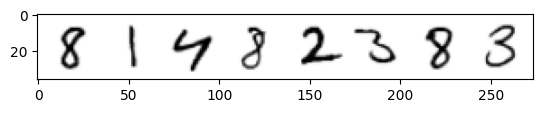

In [7]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [8]:
# def corrupt(x, amount):
#   noise = torch.rand_like(x)
#   amount = amount.reshape(-1, 1, 1, 1)
#   return x*(1-amount) + noise*amount

In [9]:
# Try DeepFool
from torch.autograd import Variable
import copy

# Build a simple model for DeepFool
model = nn.Sequential(
    # N x 1 x 32 x 32
    nn.Conv2d(1, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # N x 64 x 16 x 16
    nn.Conv2d(64, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # N x 64 x 8 x 8
    nn.Flatten(),
    nn.Linear(in_features=64*8*8, out_features=10)
)

# Move model to GPU
model = model.cuda()
loss_function = nn.CrossEntropyLoss()
model.eval()

# Training Procedure
def trainningProcedure(num_epoch, model, mini_trains, device, loss_function, optimizer):
  for epoch in range(num_epoch):
    num_iters = 0
    for x, y in mini_trains:
      model.train()
      x = x.to(device)
      y = y.to(device)
      scores = model(x)
      loss = loss_function(scores, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      num_iters += 1

def zero_gradients(x):
  if isinstance(x, torch.Tensor):
    if x.grad is not None:
      x.grad.detach_()
      x.grad.zero_()
  elif isinstance(x, collections.abc.Iterable):
    for elem in x:
      zero_gradients(elem)

def deepfool(image, net, overshoot=0.02, max_iter=50):
  """
  :param image: Size of Image HxWx3
  :param net: network (input: images, output: values of activation **BEFORE** softmax)
  :param overshoot: used as a terimnation criterion to prevent vanishing updates (default is 0.02)
  :param max_iter: maximum number of iterations (default is 50)
  :return minimal perturbation that fools the classifer, number of iterations that is required, new estimated label and perturbation image
  """
  image = image.cuda()
  net = net.cuda()

  output_pert_image = None
  label_lst = []
  label_pert = []
  for x in image:
    # 將image轉成4D, 並放入Variable中使其能計算梯度
    image_var = Variable(x[None, :, :, :], requires_grad=True)
    # 進行前向傳播
    output = net.forward(image_var)
    # 轉成numpy再flatten
    f_image = output.data.cpu().numpy().flatten()
    # argsort()得到排序的索引值, [::-1]讓排序相反, 所以得到降序排序的索引值
    I = (np.array(f_image)).flatten().argsort()[::-1]
    label = I[0]

    input_shape = x.cpu().numpy().shape
    # pert_image copy image 但修改不影響原本的image
    pert_image = copy.deepcopy(x)
    # 建立兩個全零的numpy array
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    # 對pert_image做前向傳播
    x_adv = Variable(pert_image[None, :], requires_grad=True)
    fs = net.forward(x_adv)
    k_i = label

    # 判斷被攻擊後的label是否和原本相同, 相同就繼續攻擊, 不相同就結束
    while k_i == label and loop_i < max_iter:
      # 設一個正無窮大
      pert = np.inf
      # Backword propagation
      fs[0, I[0]].backward(retain_graph=True)
      # 取得x的梯度
      grad_orig = x_adv.grad.data.cpu().numpy().copy()

      # 計算找出來的前10大類別和input的距離, 選擇最小的距離作為攻擊目標, 計算所需的攻擊擾動值
      for k in range(1, len(I)):
        # 讓x的梯度歸零
        zero_gradients(x_adv)
        fs[0, I[k]].backward(retain_graph=True)
        grad_cur = x_adv.grad.data.cpu().numpy().copy()

        # 計算梯度差異和分數差異
        w_k = grad_cur - grad_orig
        f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

        # np.linalg.norm計算歐式長度
        pert_k = abs(f_k) / np.linalg.norm(w_k.flatten())

        if pert_k < pert:
          pert = pert_k
          w = w_k

      # 計算r_i (1e-4讓計算穩定)
      r_i = (pert+1e-4) * w / np.linalg.norm(w)
      # 計算累積的peturbation
      r_tot = np.float32(r_tot + r_i)

      # 生成新的圖片, 再做一次forward看label是否有改變, 沒有改變就重新再一次
      # 因為擾動太小會需要過多次的iteration，所以會將原本算出來的擾動量*(1+overshoot)使擾動量變為1.02做attack
      if torch.cuda.is_available():
        pert_image = x + (1 + overshoot) * torch.from_numpy(r_tot).cuda()
      else:
        pert_image = x + (1 + overshoot) * torch.from_numpy(r_tot)

      x_adv = Variable(pert_image, requires_grad=True)
      fs = net.forward(x_adv)
      # 取最大的(判斷最為可能的)類別
      k_i = np.argmax(fs.data.cpu().numpy().flatten())

      loop_i += 1
    pert_image = pert_image.data
    if output_pert_image is None:
      output_pert_image = pert_image
    else:
      output_pert_image = torch.cat((output_pert_image, pert_image))
    label_lst.append(label)
    label_pert.append(k_i)
  return label_lst, label_pert, output_pert_image

In [10]:
from tqdm import tqdm
from torch.autograd import Variable

def fgsm(model, x, y, loss_function, eps, min=0, max=1): ###eps
  if not isinstance(x, Variable): # 用來判斷x是否為Variable類別
    x, y = Variable(x.to(device), requires_grad=True), Variable(y.to(device))
  x.requires_grad = True  # requires_grad=True才可使用backwards方法來計算並累積梯度
  scores = model(x)
  loss = loss_function(scores, y)
  model.zero_grad()
  loss.backward(retain_graph=True)
  return Variable(torch.clamp(x.data + eps * torch.sign(x.grad.data), min=min, max=max))
  # clamp將第一項的值限制在[min,max]之間

def accuracy(scores, y):
  predictions = scores.max(1)[1]
  acc = predictions.eq(y).sum().item()
  return acc

In [11]:
# Define loss function & optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# Start training
trainningProcedure(1, model, train_dataloader, device, loss_function, optimizer)

cuda:0


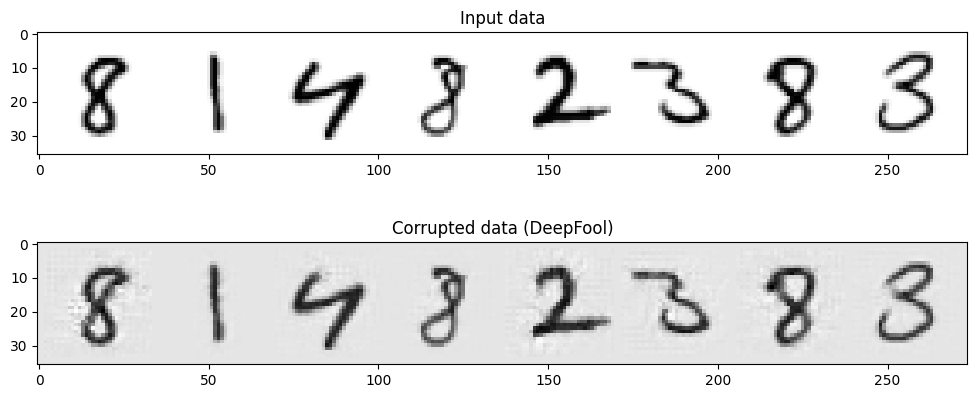

In [13]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x.cpu())[0].numpy(), cmap='Greys')

# Adding noise
# x.shape => 8, 1, 32, 32
# amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
# noised_x = corrupt(x, amount)
label_lst, label_pert, output_pert_image = deepfool(x, model)
print(output_pert_image.device)

# Plotting the noised version
axs[1].set_title('Corrupted data (DeepFool)')
axs[1].imshow(torchvision.utils.make_grid(output_pert_image.cpu())[0].numpy(), cmap='Greys')

In [14]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
  def forward(self, x):
    return self.double_conv(x)


class UNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
    super().__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(feature*2, feature, 2, 2))
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, 1)

  def forward(self, x):
    skip_connections = []
    for down in self.downs:
      x = down(x) # 3 -> 64 -> 128 -> 256 -> 512
      skip_connections.append(x)
      x = F.max_pool2d(x, (2, 2))
    x = self.bottleneck(x)
    skip_connections.reverse()

    for i in range(0, len(self.ups), 2):
      x = self.ups[i](x)
      skip_connection = skip_connections[i//2]
      concat_x = torch.cat((skip_connection, x), dim=1)
      x = self.ups[i+1](concat_x)

    return self.final_conv(x)

In [15]:
net = UNet(in_channels=1)
x = torch.rand(8, 1, 32, 32)
print(net(x).shape)

torch.Size([8, 1, 32, 32])


In [16]:
sum([p.numel() for p in net.parameters()])


31036481

Finished epoch 0. Average loss for this epoch: 0.002090
Finished epoch 1. Average loss for this epoch: 0.002233
Finished epoch 2. Average loss for this epoch: 0.002356


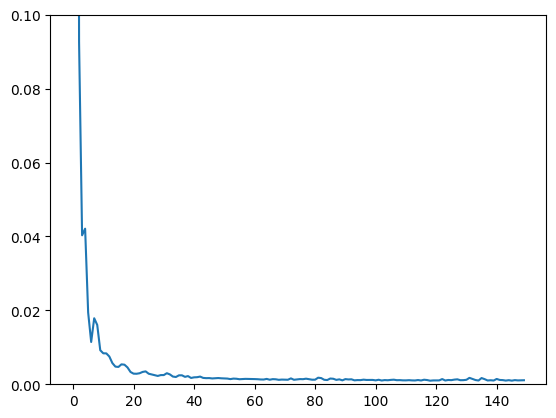

In [17]:
# Dataloader (you can mess with batch size)
batch_size = 128
from itertools import islice
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
partial_batches = list(islice(train_dataloader, 50))

# How many runs through the data should we do?
n_epochs = 3

net = UNet(in_channels=1)
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters())

# Keeping a record of the losses for later viewing
losses = []

from itertools import islice

# The training loop
for epoch in range(n_epochs):

    for x, y in partial_batches:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        # noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        # noisy_x = corrupt(x, noise_amount) # Create our noisy x
        eps = 0.15
        x, y = Variable(x.to(device)), Variable(y.to(device))
        label_lst, label_pert, noised_x = deepfool(x, model)
        # noised_x = fgsm(model, x, y, loss_function, eps)

        # Get the model prediction
        pred = net(noised_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

Original Image: tensor([4, 2, 6, 0, 0, 2, 4, 1])
DeepFool Image: tensor([4, 2, 5, 9, 5, 8, 8, 8])
UNet Image: tensor([4, 2, 6, 0, 0, 8, 4, 1])
True Label: tensor([4, 2, 6, 0, 0, 2, 4, 1])


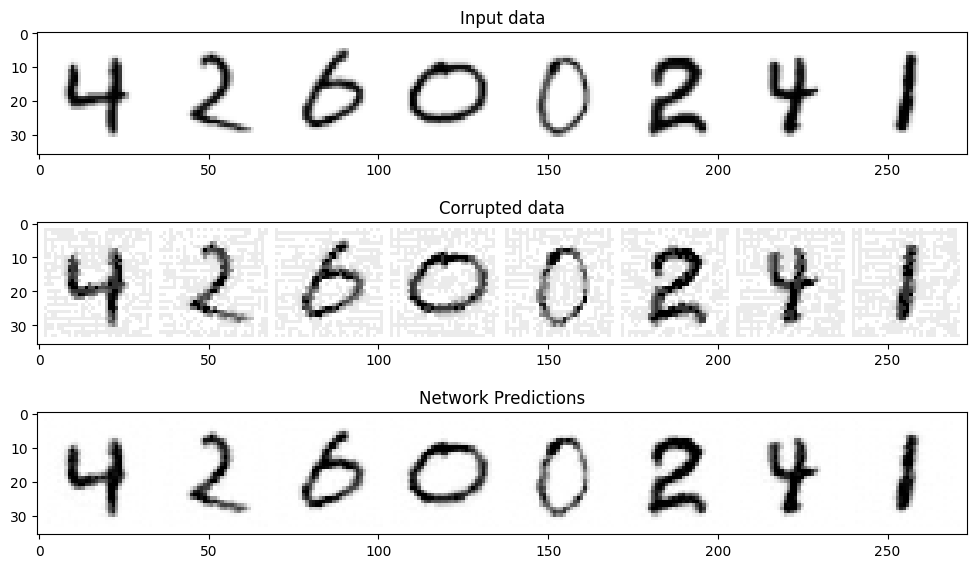

In [18]:
# Fetch some data
# x, y = next(iter(train_dataloader))
val_dataloader = DataLoader(val, batch_size=8, shuffle=True)
x, y = next(iter(val_dataloader))
# x = x[:8] # Only using the first 8 for easy plotting
# y = y[:8]

# Corrupt with a range of amounts
# amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
# noised_x = corrupt(x, amount)
eps = 0.15
x, y = Variable(x.to(device)), Variable(y.to(device))
model.eval()
# label_lst, label_pert, noised_x = deepfool(x, model)
noised_x = fgsm(model, x, y, loss_function, eps)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

import os
# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
scores = model(x)
predictions = scores.max(1)[1]
print('Original Image:', predictions.cpu())
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x.cpu())[0].numpy().clip(0, 1), cmap='Greys')
scores = model(noised_x)
predictions = scores.max(1)[1]
print('DeepFool Image:', predictions.cpu())
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x.cpu())[0].numpy().clip(0, 1), cmap='Greys')
scores = model(preds.to(device))
predictions = scores.max(1)[1]
print('UNet Image:', predictions.cpu())
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys')
print('True Label:', y.cpu())
# plt.savefig(os.path.join("./", "result_{}.png".format("DeepFool")))

In [19]:
# print(y)
# print(label_lst)
# print(label_pert)
# print(preds.data)

# np.argmax(preds.data.cpu().numpy().flatten())